To illustrate differences in methods, we will use the "Three Hump Camel" function, which has a global minimum at (0,0):

$$f(x,y) = 2x^2 - 1.05x^4 + \frac{x^6}{6} + xy + y^2$$

In [1]:
def threehumpcamel(x,y):
    return 2*x**2-1.05*x**4+x**6/6+x*y+y**2

global_min = threehumpcamel(0,0)

print "The three hump camel function has a global minimum of " + str(global_min) + " at the origin."

The three hump camel function has a global minimum of 0.0 at the origin.


To set up our grid search, we will create a grid on $[-5,5]^2$

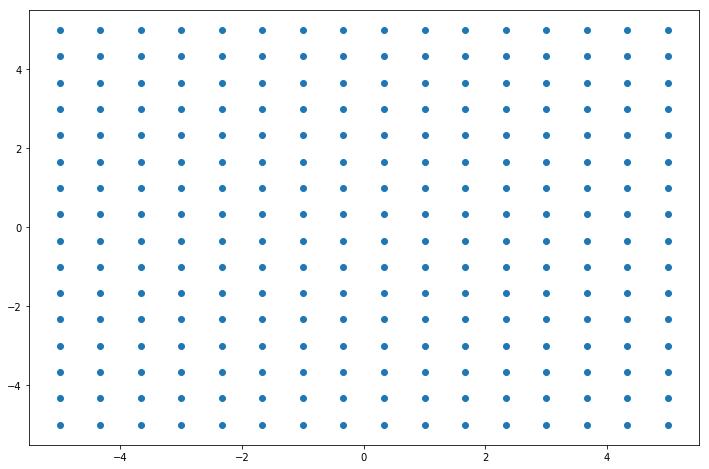

In [2]:
import numpy as np
import matplotlib.pyplot as plt

X, Y = np.meshgrid(np.linspace(-5, 5, 16), np.linspace(-5, 5, 16))

plt.figure(figsize=(12, 8))
plt.scatter(X,Y)
plt.show()

On this grid, we will evaluate the function and find the minimimum below. This gives us the following results. The minimum found by the grid is highlighted in red, while the true minimum is in black:

Grid search found a minimum of 0.209487882945 at X = 0.333333333333 and Y = -0.333333333333
This is displayed as the red point in the plot below
True minimum at the black x


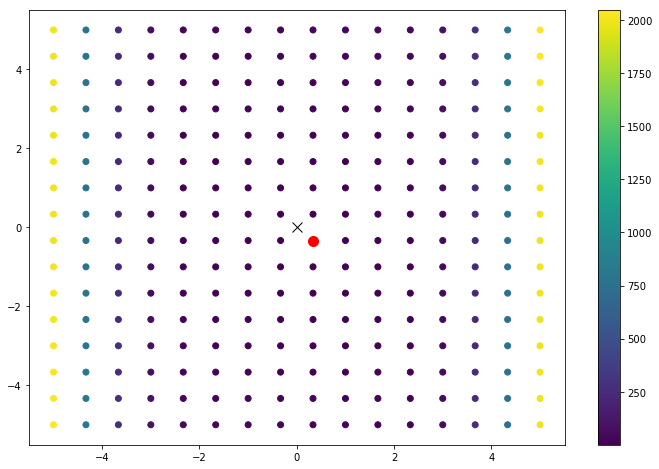

In [9]:
results_grid = threehumpcamel(X.flatten(),Y.flatten())

min_value_grid = np.min(results_grid)
min_X_grid = X.flatten()[np.argmin(results_grid)]
min_Y_grid = Y.flatten()[np.argmin(results_grid)]

print "Grid search found a minimum of " + str(min_value_grid) + " at X = " + str(min_X_grid) + " and Y = " + str(min_Y_grid)
print "This is displayed as the red point in the plot below"
print "True minimum at the black x"

import matplotlib.cm
plt.figure(figsize=(12, 8))
plt.scatter(X.flatten(),Y.flatten(),c = results_grid, cmap='viridis')
plt.plot([min_X_grid],[min_Y_grid],'r.', markersize=20.0)
plt.plot([0],[0],'k.', markersize=10.0, marker = 'x')
plt.colorbar()
plt.show()

Now we can generate a random grid with the same number of points:

Here is the generated grid:


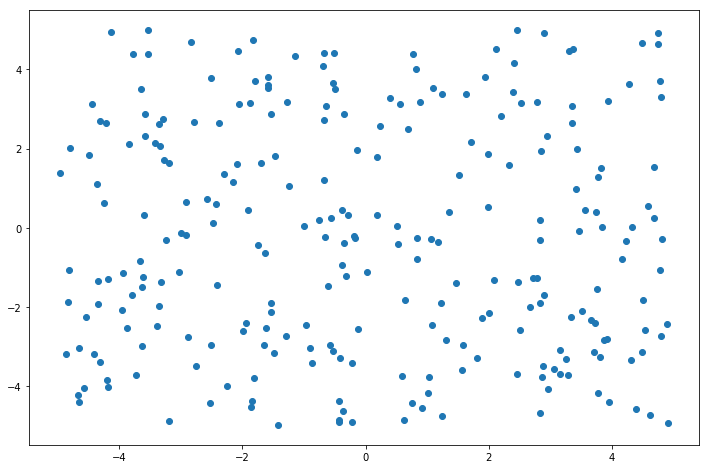

In [8]:
X_rand = np.random.uniform(low=-5.0, high=5.0, size=len(X.flatten()))
Y_rand = np.random.uniform(low=-5.0, high=5.0, size=len(Y.flatten()))

print "Here is the generated grid:"
plt.figure(figsize=(12, 8))
plt.scatter(X_rand,Y_rand)
plt.show()

This gives us a minimum at:

Random search found a minimum of 0.149137164749 at X = -0.289501167056 and Y = 0.243469432364


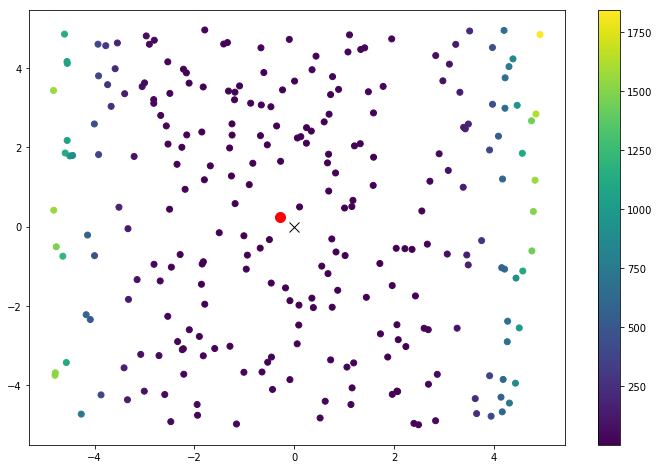

In [5]:
results_rand = threehumpcamel(X_rand.flatten(),Y_rand.flatten())

min_value_rand = np.min(results_rand)
min_X_rand = X_rand.flatten()[np.argmin(results_rand)]
min_Y_rand = Y_rand.flatten()[np.argmin(results_rand)]

print "Random search found a minimum of " + str(min_value_rand) + " at X = " + str(min_X_rand) + " and Y = " + str(min_Y_rand)

plt.figure(figsize=(12, 8))
plt.scatter(X_rand.flatten(),Y_rand.flatten(),c = results_rand, cmap='viridis')
plt.plot([min_X_rand],[min_Y_rand],'r.', markersize=20.0)
plt.plot([0],[0],'k.', markersize=10.0, marker ='x')
plt.colorbar()
plt.show()

This will be different every time, but random search typically gets us close to the minimum. Now we will try Bayesian optimization using GPyOpt.

In [6]:
from GPyOpt.methods import BayesianOptimization
import numpy as np


def threehumpcamel2(x):
    return np.atleast_2d(2*x[:,0]**2-1.05*x[:,0]**4+x[:,0]**6/6+x[:,0]*x[:,1]+x[:,1]**2).T

max_its = 100

thc_bopt = BayesianOptimization(f=threehumpcamel2, bounds=[(-5,5),(-5,5)])
thc_bopt.run_optimization(max_iter=max_its)

We run our bayesian optimization for 100 iterations after generating 5 random points to initialize our search (Note: in my experience, unfortunately this initialization can affect the outcome of the optimization)

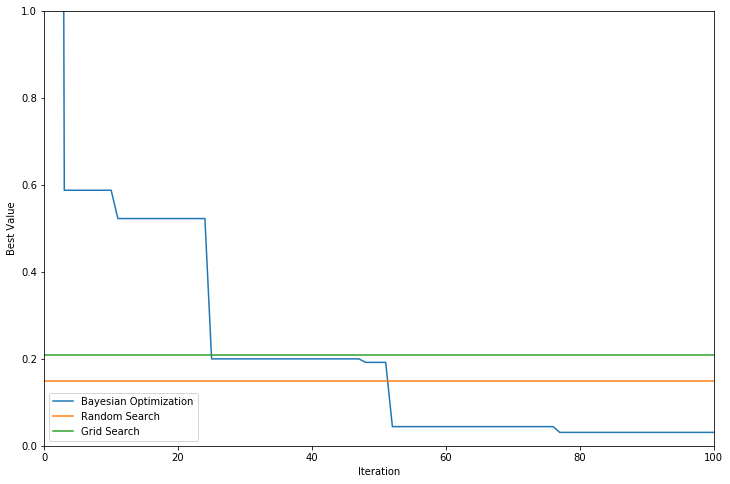

In [7]:
plt.figure(figsize=(12, 8))
plt.plot(thc_bopt.Y_best,label="Bayesian Optimization")
plt.xlabel("Iteration")
plt.ylabel("Best Value")
plt.ylim((0,1))
plt.xlim((0,100))
plt.plot([0,105],[np.min(results_rand), np.min(results_rand)],label="Random Search")
plt.plot([0,105],[np.min(results_grid), np.min(results_grid)],label="Grid Search")
plt.legend()
plt.show()

Here are the points that the algorithm visited. 

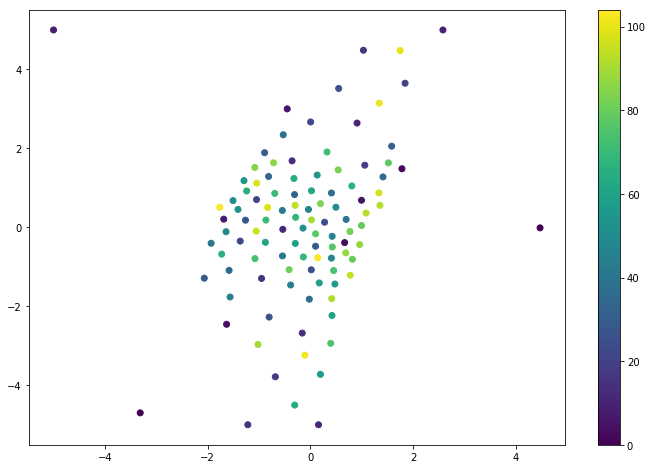

In [30]:
X_bayes = [z0[0] for z0 in thc_bopt.X]
Y_bayes = [z1[1] for z1 in thc_bopt.X]

plt.figure(figsize=(12, 8))
plt.scatter(X_bayes,Y_bayes,c=range(105))
plt.colorbar()
plt.show()

In [28]:
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

# call our new function to display the animation
display_animation(anim)

In [32]:
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(-5, 5), ylim=(-5, 5))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

# call our new function to display the animation
display_animation(anim)